In [10]:
#!/usr/bin/env python3
import scipy.io.wavfile
from python_speech_features import mfcc, delta
import numpy as np
import math

import tensorflow as tf
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.utils import plot_model
import IPython.display
import matplotlib.pyplot as plt

In [11]:
np.random.seed(1234)

# Audio analysis cell


files = [ 'cousinhenry_01_trollope_8khz.wav',
'siegeofcorinth_2_byron_8khz.wav',
'upperroom_16_ryle_8khz.wav',
'vorst_14_machiavelli_8khz.wav',
]

# This constant is the number of entries of the all_examples list below that
# correspond to one training example.
# * The 13 is magic -- it's the default number of mfcc... frequencies(?) calculated
#   by many places on the web and in the python library we used.
# * The 49 comes from a combination of our sample size and mfcc window. Our sample
#   size is half second and we calculate mfccs in a 25ms window with a 10ms stride.
#   (0.5 - 0.01) / 0.01 = 49
# * Multiply that * 2 because we are also calculating the first derivative of the
#   mfcc... cepstrum(?), which seems to be common (further adding 2nd derivative
#   is also common).
# * The + 1 is because the label for each sample comes right after the above.
height_of_one_training_example = 49 * 13 * 2 + 1

label = 0
all_examples = []
for one_file in files:
  label += 1
  rate, data = scipy.io.wavfile.read(one_file)
  total_length_of_wave = data.shape[0]
  print ("just read file number %d which contains %d audio samples and is named %s Now analying it:" % (label, total_length_of_wave, one_file))
  assert rate == 8000, "rate was %d" % rate

  half_second_length = 4000
  start_index_of_half_second = 0
  num_training_example_in_this_file = 0
  while total_length_of_wave - start_index_of_half_second >= half_second_length:
    num_training_example_in_this_file += 1
    if num_training_example_in_this_file % 500 == 0:
      print ("\t analyzing training sample number %d" % num_training_example_in_this_file)

    this_training_example_raw = data[start_index_of_half_second:start_index_of_half_second + half_second_length]
    start_index_of_half_second += half_second_length
    assert len(this_training_example_raw) == 4000, len(this_training_example_raw)
    mfccs = mfcc(this_training_example_raw, 8000)
    assert mfccs.shape == (49, 13), mfccs.shape

    # Alfredo used 2 here, and changing it doesn't change the output size, so *shrug*.
    first_derivative = delta(mfccs, 2)
    assert first_derivative.shape == (49, 13), first_derivative.shape
    all_examples.extend(mfccs.flatten().tolist())
    all_examples.extend(first_derivative.flatten().tolist())
    all_examples.append(label)
    assert len(all_examples) % height_of_one_training_example == 0, "num_training_example_in_this_file = %d" % num_training_example_in_this_file

just read file number 1 which contains 7305509 audio samples and is named cousinhenry_01_trollope_8khz.wav Now analying it:
	 analyzing training sample number 500
	 analyzing training sample number 1000
	 analyzing training sample number 1500
just read file number 2 which contains 12400013 audio samples and is named siegeofcorinth_2_byron_8khz.wav Now analying it:
	 analyzing training sample number 500
	 analyzing training sample number 1000
	 analyzing training sample number 1500
	 analyzing training sample number 2000
	 analyzing training sample number 2500
	 analyzing training sample number 3000
just read file number 3 which contains 36554719 audio samples and is named upperroom_16_ryle_8khz.wav Now analying it:
	 analyzing training sample number 500
	 analyzing training sample number 1000
	 analyzing training sample number 1500
	 analyzing training sample number 2000
	 analyzing training sample number 2500
	 analyzing training sample number 3000
	 analyzing training sample number 3

In [12]:
np.random.seed(123456)

# This cell massages the audio features into a format Keras likes and splits into test/dev sets.

# TODO(dgrogan): Parts of the first half and last half of this cell are inverses and can be combined.
all_examples_np = np.array(all_examples)
all_examples_np = all_examples_np.reshape((height_of_one_training_example, -1), order='F')

#print ("all_examples_np.shape = %s, so we have %d training samples" % (all_examples_np.shape, all_examples_np.shape[1]))
assert all_examples_np[-1, 0] == 1, "make sure the last row labels the first column as belonging to file number 1 %s" % all_examples_np[-1, 0]

shuffled_examples = all_examples_np.T
np.random.shuffle(shuffled_examples)
shuffled_examples = shuffled_examples.T

# I changed to 0.9 when I thought we might not have enough data. We can change it back to whatever.
training_pct = 0.9

number_of_training_examples = int(math.ceil(all_examples_np.shape[1] * training_pct))

# The labels are the last entry in each of the columns, hence the -1 below.
X_train = shuffled_examples[0:-1, 0:number_of_training_examples]
Y_train = shuffled_examples[-1:, 0:number_of_training_examples]
X_dev   = shuffled_examples[0:-1, number_of_training_examples:]
Y_dev   = shuffled_examples[-1:, number_of_training_examples:]

# The labels in Y are an integer corresponding to the speaker number.
# In Keras, you want (number of data, attributes). So we reshape.
# Want: (see coursera M4 - Keras Tutorial)
# if training_pct = 0.8, (11853, 1274) (11853, 1) (2963, 1274) (2963, 1)
X_train = X_train.T
Y_train = Y_train.T
X_dev = X_dev.T
Y_dev = Y_dev.T

# Sanity check the train/dev shapes.
print(X_train.shape, Y_train.shape, X_dev.shape, Y_dev.shape)

# Sanity check the one-hot encoding.
print(Y_train[0:5])
print(Y_dev[0:5])
Y_train = to_categorical(Y_train - 1) # -1 because to_categorical seems to expect labels to start at 0
Y_dev = to_categorical(Y_dev - 1)
print(Y_train[0:5])
print(Y_dev[0:5])

(13335, 1274) (13335, 1) (1481, 1274) (1481, 1)
[[2.]
 [2.]
 [2.]
 [3.]
 [3.]]
[[3.]
 [3.]
 [3.]
 [4.]
 [3.]]
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


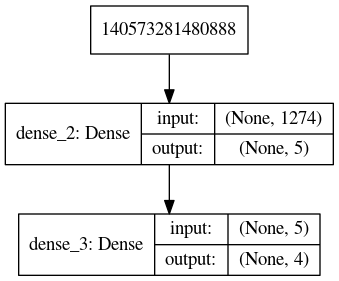

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5)                 6375      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 24        
Total params: 6,399
Trainable params: 6,399
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
#Keras
model = tf.keras.Sequential()

#hidden layers
model.add(layers.Dense(5, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

keras.utils.plot_model(model, to_file='test_keras_plot_model.png', show_shapes=True)
display(IPython.display.Image('test_keras_plot_model.png'))
print(model.summary())
# I don't know where 140240419526080 in the picture came from

In [14]:
%%time
history_object = model.fit(X_train, Y_train, epochs=50, batch_size=128, verbose=2, shuffle=True,
         validation_data=(X_dev, Y_dev))


Train on 13335 samples, validate on 1481 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 2s - loss: 1.1665 - acc: 0.7714 - val_loss: 0.6332 - val_acc: 0.8130
Epoch 2/50
 - 1s - loss: 0.5421 - acc: 0.8588 - val_loss: 0.5286 - val_acc: 0.8515
Epoch 3/50
 - 1s - loss: 0.4428 - acc: 0.8826 - val_loss: 0.4591 - val_acc: 0.8744
Epoch 4/50
 - 1s - loss: 0.3733 - acc: 0.8901 - val_loss: 0.4801 - val_acc: 0.8845
Epoch 5/50
 - 1s - loss: 0.3167 - acc: 0.9044 - val_loss: 0.4419 - val_acc: 0.8913
Epoch 6/50
 - 1s - loss: 0.2695 - acc: 0.9204 - val_loss: 0.3810 - val_acc: 0.9075
Epoch 7/50
 - 1s - loss: 0.2195 - acc: 0.9333 - val_loss: 0.3559 - val_acc: 0.9237
Epoch 8/50
 - 1s - loss: 0.1950 - acc: 0.9399 - val_loss: 0.3264 - val_acc: 0.9196
Epoch 9/50
 - 1s - loss: 0.1736 - acc: 0.9451 - val_loss: 0.3354 - val_acc: 0.9163
Epoch 10/50
 - 1s - loss: 0.1585 - acc: 0.9486 - val_loss: 0.3139 - val_acc: 0.9156
Epoch 11/50
 - 1s - loss: 0.1406 - acc: 0.9530 - val_loss: 0.3058 - val_

In [15]:
print(history_object.history)

{'val_loss': [0.6331565333813288, 0.528595754337182, 0.45910362594438353, 0.4800785100999352, 0.441894822753337, 0.38098537905807034, 0.355909694999879, 0.3264430860544201, 0.3353775296961432, 0.31389301673211734, 0.30576580044468216, 0.28549642261220826, 0.2933707859651371, 0.2780746061060575, 0.2736844410069644, 0.2723250223083483, 0.2495713515570645, 0.25237577634434055, 0.2724559216443789, 0.24645894370434818, 0.2711183970579016, 0.26938684300785526, 0.250885889688752, 0.2549594361221847, 0.25757907398402247, 0.2780768925639764, 0.24744400376005, 0.2919131080940074, 0.2536975211947452, 0.2601413220710484, 0.27620964956637734, 0.2855874792013033, 0.31145813026837127, 0.29375170586803007, 0.30237355003237804, 0.2848084618882663, 0.292486684717575, 0.28654643275462477, 0.3142280443989691, 0.32173925973248596, 0.3257654828247712, 0.36632918192678654, 0.3188041655458686, 0.3186093281242672, 0.3175995506643042, 0.30958291079288075, 0.33697482815753116, 0.3329369738687944, 0.3720055753761

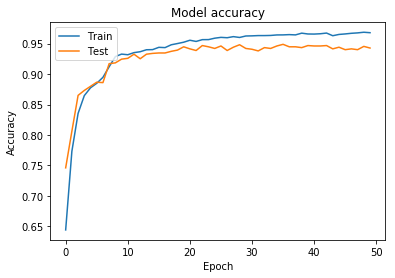

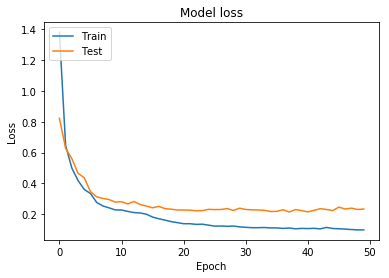

In [8]:
# Plot training & validation accuracy values
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()